# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [4]:
import cv2
import matplotlib.image as mpimg
import scipy.ndimage
import pandas as pd
import random
import numpy as np

In [2]:
# Load pickled data
import pickle



training_file = "../train.p"
testing_file = "../test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
df = pd.read_csv('./signnames.csv')
df_dict = df.to_dict()
sign_dict = df_dict['SignName'] # class labels

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np
# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.union1d(y_train, []))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

<Container object of 43 artists>

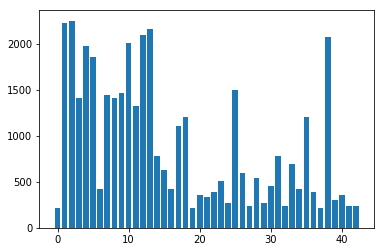

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random
import numpy as np

bin_count = np.bincount(y_train)
x = np.arange(0,43,1)
plt.bar(x, bin_count)

### Unbalanced data
The data provided has unbalanced data; one way to address this would be data augmentation.
For this project, I generated 3000 samples per class which includes the preprocessing steps.

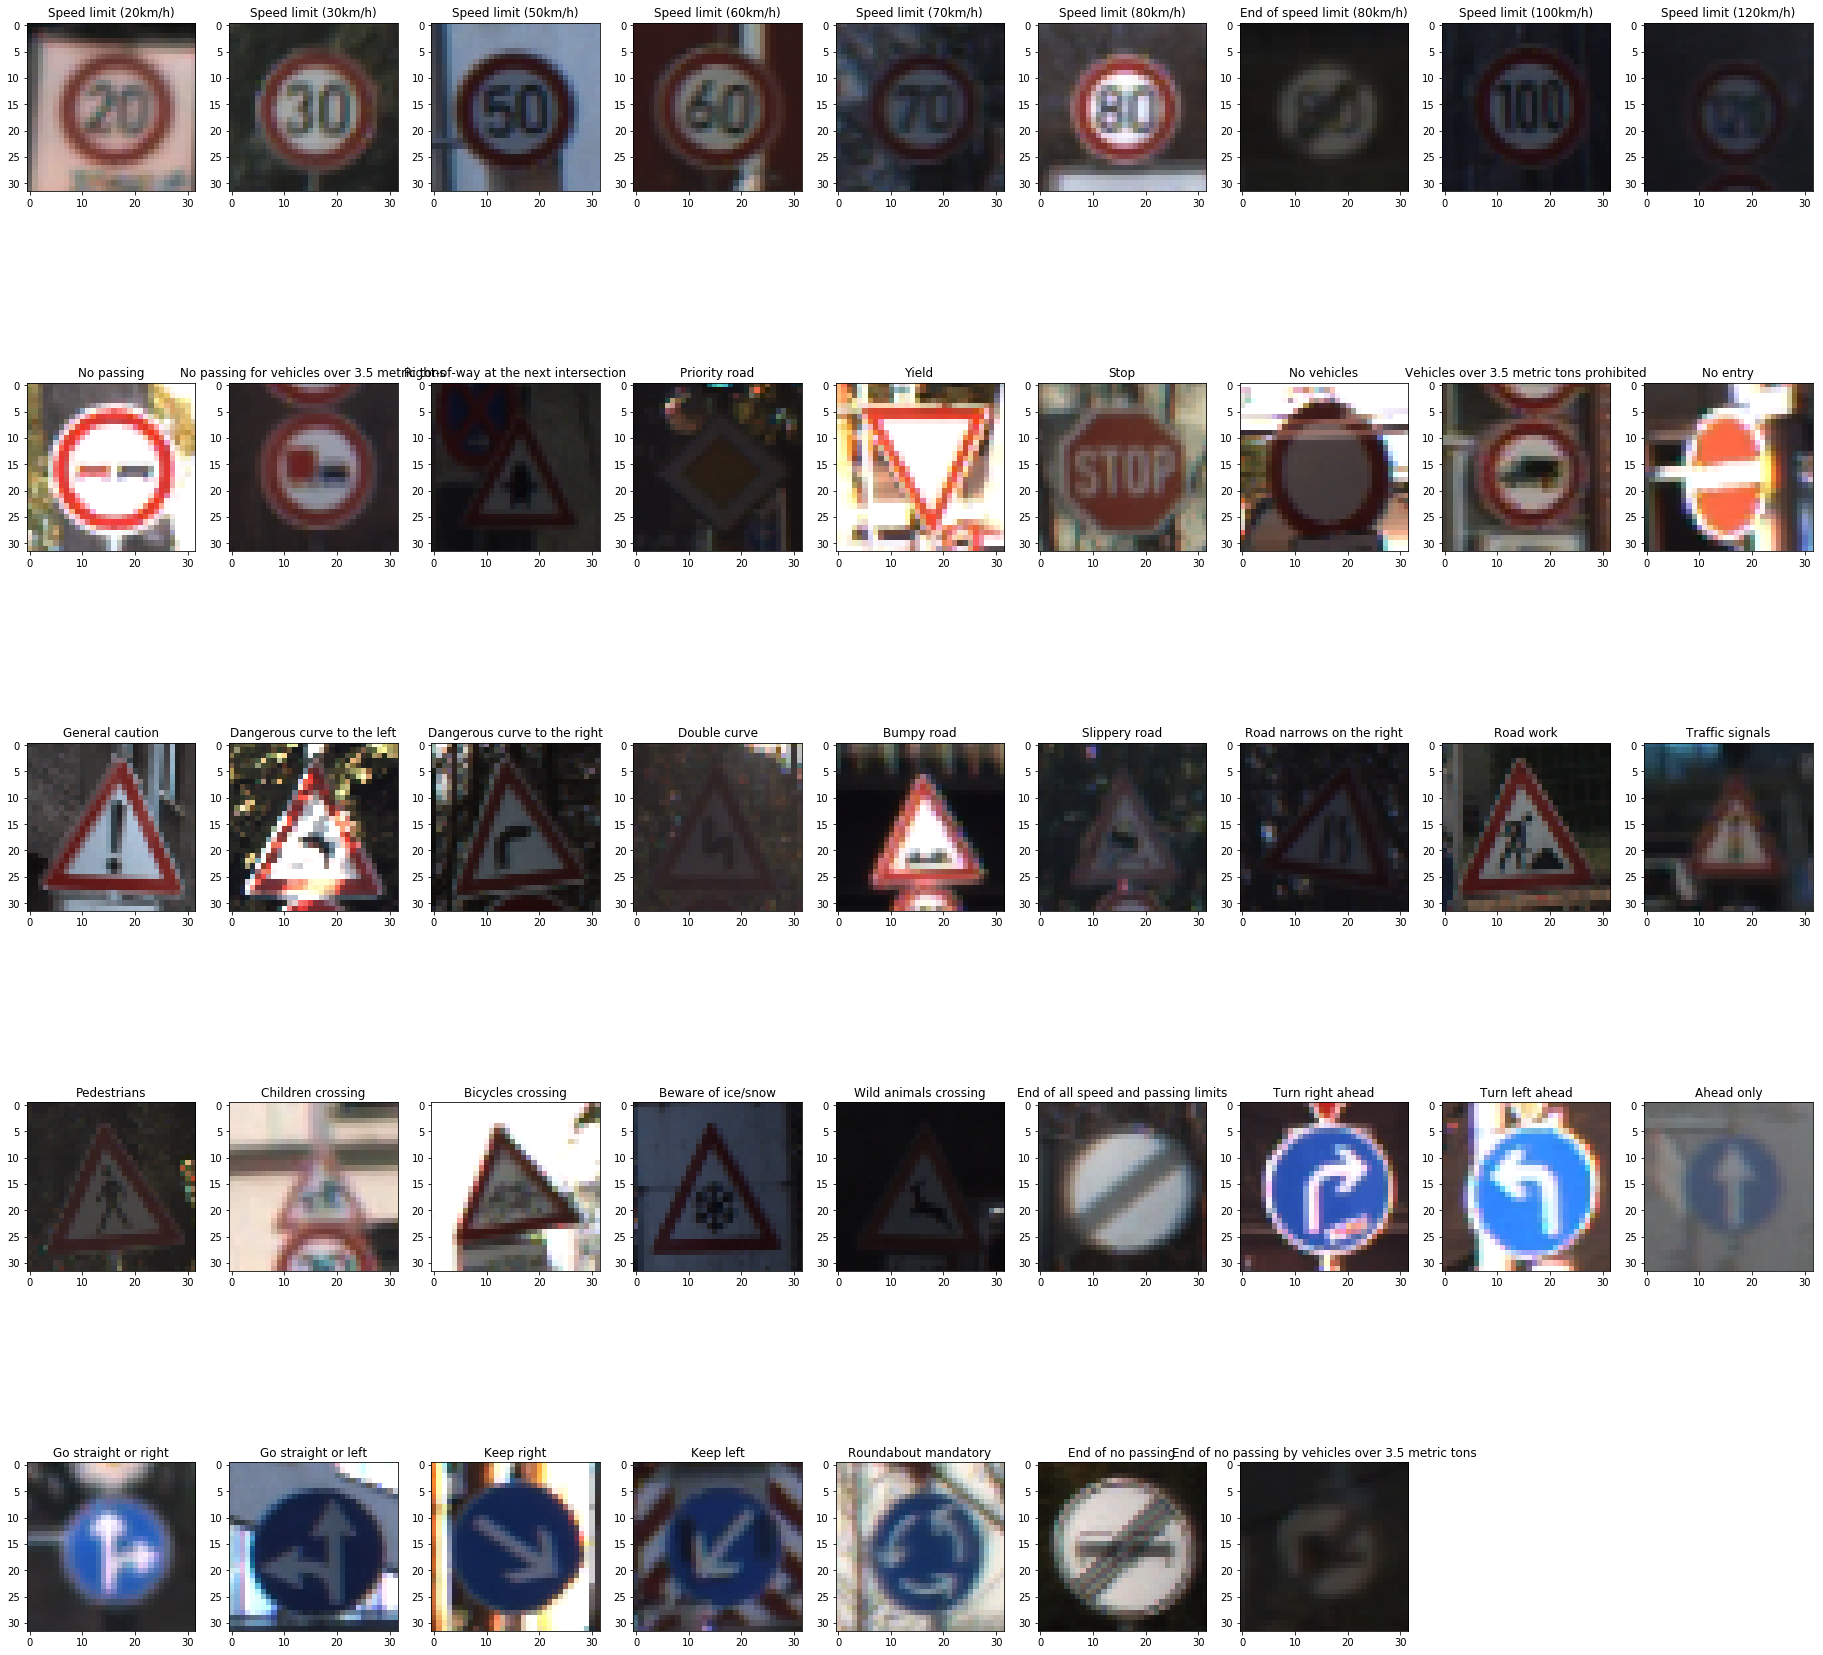

In [8]:
fig1 = plt.figure(figsize=(32,32))
for i in range(43):
    new_indices = np.where(y_train == i)[0]
    rand_ind = np.random.randint(len(new_indices))
    index = new_indices[rand_ind]
    image1 = X_train[index]
    ax = fig1.add_subplot(5,9, i+1)
    ax.imshow(image1)
    ax.set_title(sign_dict[i])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def image_rotate(image, angle):
    '''
    rotate imagesas preprocessing step
    '''
    rows,cols = image.shape[:2]
    rmat = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.uniform(-angle, angle), 1.0)
    img_rot = cv2.warpAffine(image , rmat, (cols,rows))
    return img_rot

def image_translate(image, tvalue):
    '''
    Translate image left or right randomly
    '''
    rows,cols = image.shape[:2]
    rx, ry = np.random.uniform(-tvalue, tvalue, 2)
    tmat = np.float32([[1,0,rx],[0,1,ry]])
    trans_image = cv2.warpAffine(image, tmat, (cols,rows))
    return trans_image

def image_hsv(image, v_value):
    '''
    change the value channel to increase the brightness
    as a way to incorporate shadows and bad light
    '''
    rows,cols = image.shape[:2]
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v += v_value
    final_hsv = cv2.merge((h, s, v))
    final_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return final_img

### The following code auguments data to make the provided dataset balanced

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


<Container object of 43 artists>

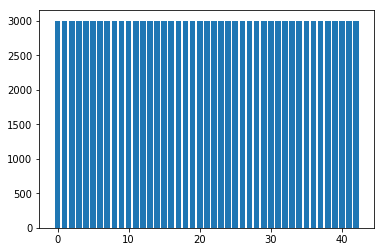

In [10]:
for i in range(43):
    final_list, final_y = [], []
    add_more = 2600 - bin_count[i]
    new_indices = np.where(y_train == i)
    num_indices = len(new_indices[0])
    for j in range(add_more):
        rand_ind = np.random.randint(num_indices)
        temp_image_rot = image_rotate(X_train[new_indices[0][rand_ind]], 10)
        final_transform = image_translate(temp_image_rot, 5)
        #final_image = np.expand_dims(final_transform, axis = 2)
        final_list.append(final_transform)
        final_y.append(i)
    for k in range(400):
        rand_ind = np.random.randint(num_indices)
        hsv_transform = image_hsv(X_train[new_indices[0][rand_ind]], 20)
        final_list.append(hsv_transform)
        final_y.append(i)
    X_train = np.append(X_train, final_list, axis = 0)
    y_train = np.append(y_train, final_y, axis = 0)

bin_count = np.bincount(y_train)
x = np.arange(0,43,1)
plt.bar(x, bin_count)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**  I used random rotation, translation and varying the brightness as techniques to preprocess the data.
I used them as they cover most of the scenarios bad light, orientations and deformities in the signs. 

In [ ]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I split the samples, from train.p, into training and validations sets, where the validation set is 20% of the complete augmented training set.

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.
    conv1_W_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b_1 = tf.Variable(tf.zeros(16))
    conv1_1   = tf.nn.conv2d(x, conv1_W_1, strides=[1, 1, 1, 1], padding='SAME') + conv1_b_1

    # SOLUTION: Activation.
    conv1_1 = tf.nn.relu(conv1_1)
    
    # SOLUTION: Layer 2: Convolutional. Input = 32x32x16. Output = 32x32x16.
    conv1_W_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv1_b_2 = tf.Variable(tf.zeros(16))
    conv1_2   = tf.nn.conv2d(conv1_1, conv1_W_2, strides=[1, 1, 1, 1], padding='SAME') + conv1_b_2
    
    # SOLUTION: Activation.
    conv1_2 = tf.nn.relu(conv1_2)
    
    # SOLUTION: Layer 3: Convolutional. Input = 32x32x16. Output = 28x28x16.
    conv1_W_3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv1_b_3 = tf.Variable(tf.zeros(16))
    conv1_3   = tf.nn.conv2d(conv1_2, conv1_W_3, strides=[1, 1, 1, 1], padding='VALID') + conv1_b_3
    
    # SOLUTION: Activation.
    conv1_p = tf.nn.relu(conv1_3)

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1_p, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 4: Convolutional. Input = 14x14x16 Output = 10x10x16.
    conv2_W_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv2_b_1 = tf.Variable(tf.zeros(16))
    conv2_1   = tf.nn.conv2d(conv1, conv2_W_1, strides=[1, 1, 1, 1], padding='VALID') + conv2_b_1
    
    # SOLUTION: Activation.
    conv2_1 = tf.nn.relu(conv2_1)
    
    # SOLUTION: Layer 5: Convolutional. Input = 10x10x16. Output = 10x10x16.
    conv2_W_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv2_b_2 = tf.Variable(tf.zeros(16))
    conv2_2   = tf.nn.conv2d(conv2_1, conv2_W_2, strides=[1, 1, 1, 1], padding='SAME') + conv2_b_2
    # SOLUTION: Activation.
    conv2_2 = tf.nn.relu(conv2_2)
    
    # SOLUTION: Layer 5: Convolutional. Input = 10x10x16. Output = 10x10x16.
    conv2_W_3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv2_b_3 = tf.Variable(tf.zeros(16))
    conv2_3   = tf.nn.conv2d(conv2_2, conv2_W_3, strides=[1, 1, 1, 1], padding='SAME') + conv2_b_3
    # SOLUTION: Activation.
    conv2_3 = tf.nn.relu(conv2_3)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [14]:

# define placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

# learning rate
rate = 0.001

# define the loss and optimizer as Adam
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

Input(32 x 32 x 3) -> 
Convolutional (32x32x16) -> 
ReLu -> 
Convolutional (32x32x16) -> 
ReLu -> 
Convolutional (28x28x16) -> 
ReLu -> 
Pooling (14 x 14 x 16) ->  
Convolutional (10x10x16) ->
ReLu ->
Convolutional (10x10x16) -> 
ReLu ->
Convolutional (10x10x16) -> 
ReLu ->
Convolutional (10x10x16) -> 
ReLu ->
Convolutional (5x5x16) -> 
ReLu ->
Flatten(400) ->
FC(120)->
FC(84) ->
FC(43)



#### I have decided to use a deeper model to get used to tensorflow, but a simple LeNet with 1x1 convolutions will do the trick

In [20]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.539

EPOCH 2 ...
Validation Accuracy = 0.748

EPOCH 3 ...
Validation Accuracy = 0.812

EPOCH 4 ...
Validation Accuracy = 0.849

EPOCH 5 ...
Validation Accuracy = 0.863

EPOCH 6 ...
Validation Accuracy = 0.890

EPOCH 7 ...
Validation Accuracy = 0.887

EPOCH 8 ...
Validation Accuracy = 0.925

EPOCH 9 ...
Validation Accuracy = 0.930

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.947

EPOCH 12 ...
Validation Accuracy = 0.938

EPOCH 13 ...
Validation Accuracy = 0.948

EPOCH 14 ...
Validation Accuracy = 0.935

EPOCH 15 ...
Validation Accuracy = 0.956

EPOCH 16 ...
Validation Accuracy = 0.950

EPOCH 17 ...
Validation Accuracy = 0.953

EPOCH 18 ...
Validation Accuracy = 0.937

EPOCH 19 ...
Validation Accuracy = 0.964

EPOCH 20 ...
Validation Accuracy = 0.965

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I used Adam optimizer, with a batch size of 128.
Number of epochs used is 20 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.940


**Answer:**  I used a deeper version of LeNet. My initial thoughs were deeper models would give you better accuracies at the risk of overfitting. I commited to the model with many weights parameters and sticked with it to learn Tensorflow basics. The solution I proposed gets a vaidation score of 0.96 and the score on test set is 0.94

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [39]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import matplotlib.image as mpimg
import scipy.ndimage   
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
new_labels = [34, 2, 28, 27, 23]
new_images = np.empty((len(new_labels),32,32,3), dtype=np.uint8)

ii=0
for i in range(5):
    imgfile = './testsigns/sign' + str(i+1) + '.png'
    image = scipy.ndimage.imread(imgfile)
    image = cv2.resize(image,(32,32))
    new_images[ii] = image[:,:,0:3]
    ii +=1

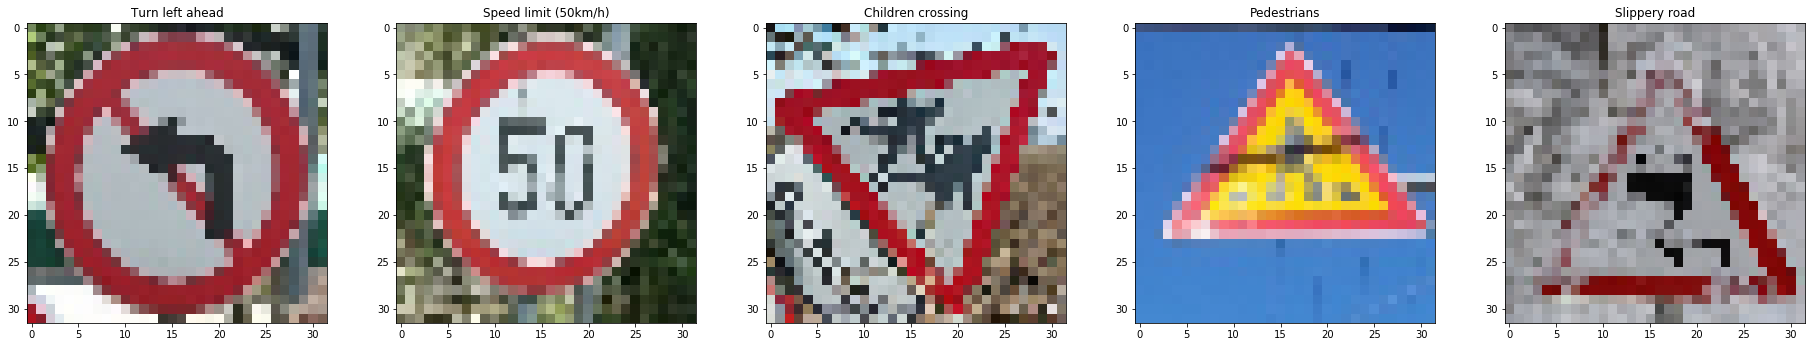

In [40]:
fig = plt.figure(figsize=(32,32))
i = 0
for (i,image) in enumerate(new_images):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(image)
    ax.set_title(sign_dict[new_labels[i]])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I used high quality images and resizing them to 32 x 32 results in very noisy images.
I expected to get atleast 1 out of the 5 right just by looking at them. As I expected the accuracy of on these 5 images are given below.

In [33]:
sign_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [41]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_images_accuracy = evaluate(new_images[:len(new_labels)], new_labels)
    print("Test Accuracy = {:4.2f}%".format(100. * new_images_accuracy))

Test Accuracy = 20.00%


**Answer:** No, the accuracy of these new data is quite low. It could be because of major down-sampling without cropping. I did not use cropping, to check if the model could still predict because of convolutions.
It could predict the Speed limit (50km/h) sign correctly

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [50]:
slogits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(slogits, k=3)
n_images = new_images.shape[0]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    slogits1 = sess.run(slogits, feed_dict={x: new_images})
    topk5 = sess.run(top_k, feed_dict={x: new_images})
    top_values, top_indices = topk5
    
    
top_values

array([[  9.99077320e-01,   5.99229184e-04,   1.50543856e-04],
       [  9.97309208e-01,   2.64937640e-03,   4.13130947e-05],
       [  6.18415952e-01,   2.32399255e-01,   1.29337952e-01],
       [  9.74188566e-01,   1.48852747e-02,   1.08104050e-02],
       [  9.56084490e-01,   2.47673430e-02,   7.86995236e-03]], dtype=float32)

In [47]:
for (i,k) in enumerate(top_indices):
    print(k, new_labels[i])

[38 40  1] 34
[2 1 0] 2
[11 40 12] 28
[11 40 30] 27
[25 23 11] 23


In [48]:
for (i,k) in enumerate(top_indices):
    print(sign_dict[k[0]], "  ", sign_dict[k[1]], "  ", sign_dict[k[2]], ", True label::  ", sign_dict[new_labels[i]])

Keep right    Roundabout mandatory    Speed limit (30km/h) , True label::   Turn left ahead
Speed limit (50km/h)    Speed limit (30km/h)    Speed limit (20km/h) , True label::   Speed limit (50km/h)
Right-of-way at the next intersection    Roundabout mandatory    Priority road , True label::   Children crossing
Right-of-way at the next intersection    Roundabout mandatory    Beware of ice/snow , True label::   Pedestrians
Road work    Slippery road    Right-of-way at the next intersection , True label::   Slippery road


**Answer:**  The trained model  is certain about the speed limit (50km/h), but fails in other cases.
The blurry image of (Children crossing) and (Pedestrains) are confused with blurred image of (Right-of-way at the next intersection)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.